In [48]:
import pandas as pd
import numpy as np
import os
import plotly.express as px
import plotly.figure_factory as ff
import missingno as msno 
import scipy.stats as sps
import math
import statsmodels.api as sm
import glob

In [2]:
def date_transform(df, *date_vars, formato='%Y-%m-%d'):
    for dates in date_vars:
        dates = [i for i in date_vars]
    
    for dat in dates:
        df[dat] = pd.to_datetime(df[dat], format=formato, errors='coerce')

In [3]:
def clean_str(row):
    import re
    #Remove all characters that are not numbers or letters
    if type(row) == str:
        return re.sub(r'[^a-zA-Z0-9]+' , '', row)
    else:
        return row

In [ ]:
import glob
import os
path = 'C:/Users/crm107710/Downloads/dados/'
df = pd.concat([pd.read_csv(f, encoding='utf8', sep=',', low_memory=False) 
                for f in glob.glob(os.path.join(path, "*.csv"))], 
               sort = False, ignore_index=True)

In [16]:
variables = ['CODMUNNASC', 'LOCNASC', 'def_loc_nasc', 'IDADEMAE', 
             'def_est_civil', 'def_escol_mae', 'CODOCUPMAE',
            'QTDFILVIVO', 'QTDFILMORT', 'CODMUNRES', 'def_gestacao', 
             'def_gravidez', 'def_parto', 'def_consultas', 'data_nasc',
            'dia_semana_nasc', 'HORANASC', 'def_sexo',
            'APGAR1', 'APGAR5', 'def_raca_cor', 'PESO', 'def_anomalia',
            'CODANOMAL', 'NATURALMAE', 'CODMUNNATU', 'CODUFNATU',
            'ESCMAE2010', 'SERIESCMAE', 'DTNASCMAE', 'RACACORMAE', 
            'QTDGESTANT', 'QTDPARTNOR', 'QTDPARTCES', 'IDADEPAI',
            'SEMAGESTAC', 'TPMETESTIM', 'CONSPRENAT', 'MESPRENAT',
            'TPAPRESENT', 'STTRABPART', 'STCESPARTO', 'TPNASCASSI', 
            'TPFUNCRESP', 'DTDECLARAC', 'CODPAISRES', 'TPROBSON',
            'PARIDADE', 'KOTELCHUCK', 'nasc_MUNNOMEX', 'nasc_MSAUDCOD',
            'nasc_RSAUDCOD', 'nasc_CSAUDCOD', 'nasc_LATITUDE', 'nasc_LONGITUDE',
            'nasc_codigo_adotado', 'res_MUNNOMEX', 'res_MSAUDCOD',
            'res_RSAUDCOD', 'res_LATITUDE', 'res_LONGITUDE', 
             'res_codigo_adotado', 'codanomal_categoria', 
             'codanomal_subcategoria', 'def_parto_prematuro']

In [210]:
df = pd.read_csv('C:/Users/joaom/Downloads/Final_sao_paulo.csv', low_memory=False)

* Removed 'KOTELCHUCK', to many missing, and we have the individual data that is used to calculate de index
* Removed many variable related to the risk of pregnancy, because they are incorporated in the Robson score
* Won't use GeoSES, individual variables like education will be better than a consolidated index for the whole municipality

In [ ]:
'DTNASCMAE' comparar com completude da idademae

In [ ]:
'DTDECLARAC' comparar com data de nascimento

### Select variables

In [143]:
variables = ['def_loc_nasc', 'DTNASCMAE', 'IDADEMAE', 'def_est_civil', 'def_escol_mae',
             'QTDFILVIVO', 'QTDFILMORT', 'def_gravidez', 
             'TPROBSON', 'def_parto', 'def_consultas', 'data_nasc',
             'dia_semana_nasc', 'def_raca_cor', 'PESO', 'RACACORMAE', 
             'QTDGESTANT', 'IDADEPAI','MESPRENAT', 'TPNASCASSI', 
             'DTDECLARAC',
             'nasc_MUNNOMEX', 'nasc_codigo_adotado', 'CODMUNNASC', 
             'res_MUNNOMEX', 'res_codigo_adotado', 'CODMUNRES',
             'def_parto_prematuro']

In [211]:
df  = df[variables].copy()

### Adjust some variables

In [212]:
#Variables coded with numbers that need to be transformed to description
# ESCMAE2010 = {0:'Sem escolaridade', 1:'Fundamental I (1a a 4a série)', 
#                 2:'Fundamental II (5a a 8a série)', 3:'Médio (antigo 2o Grau)',
#                 4:'Superior incompleto', 5:'Superior completo', 9:'Ignorado'} 

# TPAPRESENT = {1:'Cefálico', 2:'Pélvica ou podálica', 
#               3:'Transversa', 9:'Ignorado'}

TPNASCASSI = {1:'Médico', 2:'Enfermeira/obstetriz', 3:'Parteira', 4:'Outros',
              9:'Ignorado'}
# TPFUNCRESP = {1:'Médico', 2:'Enfermeiro', 3:'Parteira', 
#               4:'Funcionário docartório', 5:'Outros'}

# STTRABPART = {1:'Sim', 2:'Não', 3:'Não se aplica', 9:'Ignorado'}, 

# STCESPARTO = {1:'Sim', 2:'Não', 3:'Não se aplica', 9:'Ignorado'}

RACACORMAE = {1:'Branca', 2:'Preta', 3:'Amarela', 4:'Parda', 5:'Indígena', 9:np.nan}


In [213]:
for key, value in {'TPNASCASSI':TPNASCASSI, 
                  'RACACORMAE':RACACORMAE}.items():
    df[key] = df[key].replace(value)

In [9]:
# #Replace numbers by descriptions
# for key, value in {'ESCMAE2010':ESCMAE2010, 'TPAPRESENT':TPAPRESENT, 
#                    'TPNASCASSI':TPNASCASSI, 'TPFUNCRESP':TPFUNCRESP, 
#                    'STTRABPART':STTRABPART, 'STCESPARTO':STCESPARTO,
#                   'RACACORMAE':RACACORMAE}.items():
#     df[key] = df[key].replace(value)

In [214]:
#Replace "Ignorado" with nan
df.replace({'Ignorado':np.nan}, inplace=True)

In [215]:
#Transform dates
date_transform(df, 'data_nasc', 'DTNASCMAE', 'DTDECLARAC')

In [216]:
df['IDADEPAI'] = pd.to_numeric(df['IDADEPAI'], errors='coerce')

In [ ]:
df.loc[(df['nasc_MUNNOMEX'].str.contains('ignorado', case=False)), 'nasc_MUNNOMEX'].unique()

In [ ]:
df.loc[(df['res_MUNNOMEX'].str.contains('ignorado', case=False)), 'res_MUNNOMEX'].unique()

In [217]:
df.replace({'MUNICIPIO IGNORADO - SP':np.nan}, inplace=True)

In [218]:
df['nasc_MUNNOMEX'].isnull().mean()

1.5385791623833017e-06

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8449354 entries, 0 to 8449353
Data columns (total 29 columns):
 #   Column               Dtype         
---  ------               -----         
 0   def_loc_nasc         object        
 1   DTNASCMAE            datetime64[ns]
 2   IDADEMAE             float64       
 3   def_est_civil        object        
 4   def_escol_mae        object        
 5   QTDFILVIVO           float64       
 6   QTDFILMORT           float64       
 7   def_gestacao         object        
 8   def_gravidez         object        
 9   TPROBSON             float64       
 10  def_parto            object        
 11  def_consultas        object        
 12  data_nasc            datetime64[ns]
 13  dia_semana_nasc      object        
 14  def_raca_cor         object        
 15  PESO                 float64       
 16  RACACORMAE           object        
 17  QTDGESTANT           float64       
 18  IDADEPAI             float64       
 19  MESPRENAT            

In [167]:
df['def_parto_prematuro'].value_counts(dropna=False, normalize=True)

Termo                0.857925
Prematuro            0.055220
Inconclusivo-IG      0.048378
Inconclusivo-Peso    0.036523
NaN                  0.001953
Name: def_parto_prematuro, dtype: float64

In [219]:
df['ano'] = df['data_nasc'].dt.year

<AxesSubplot:>

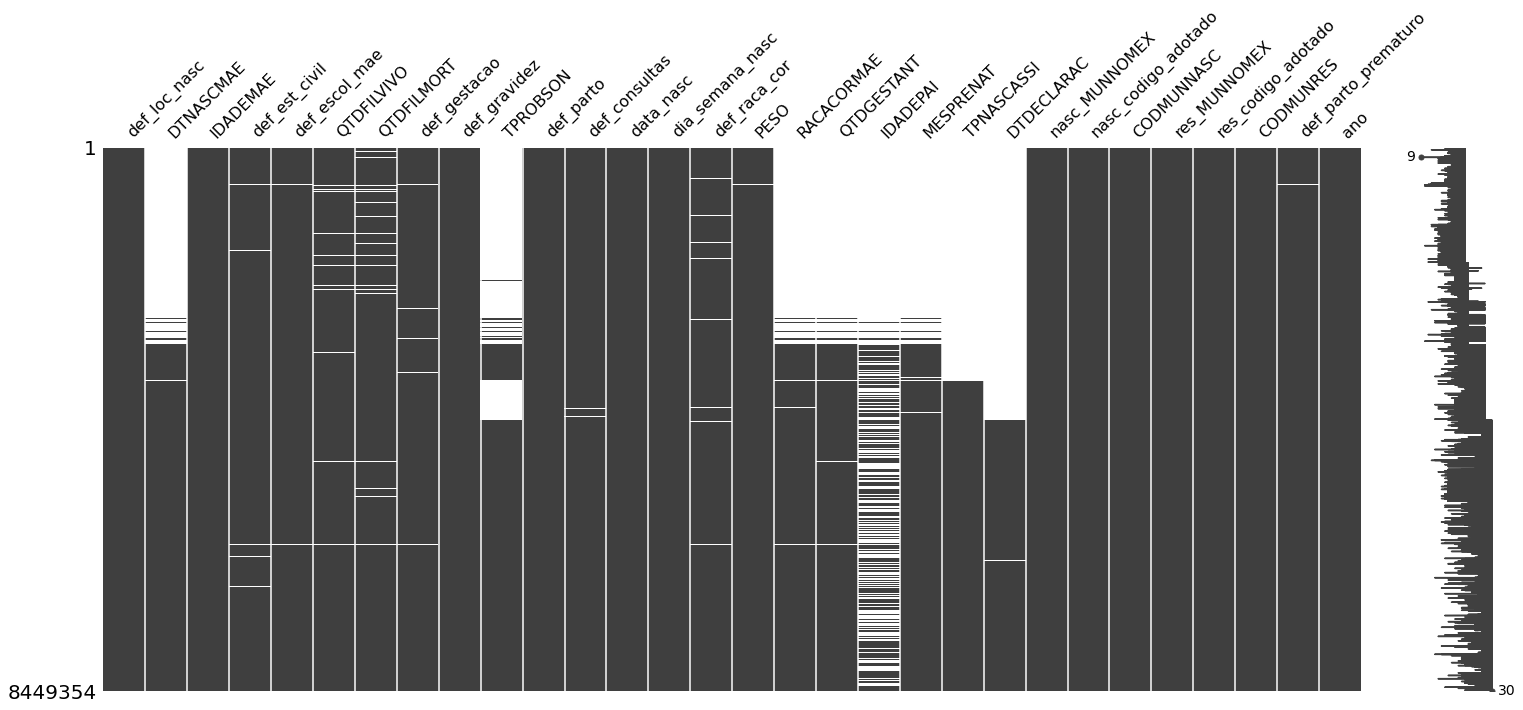

In [80]:
msno.matrix(df)

<AxesSubplot:>

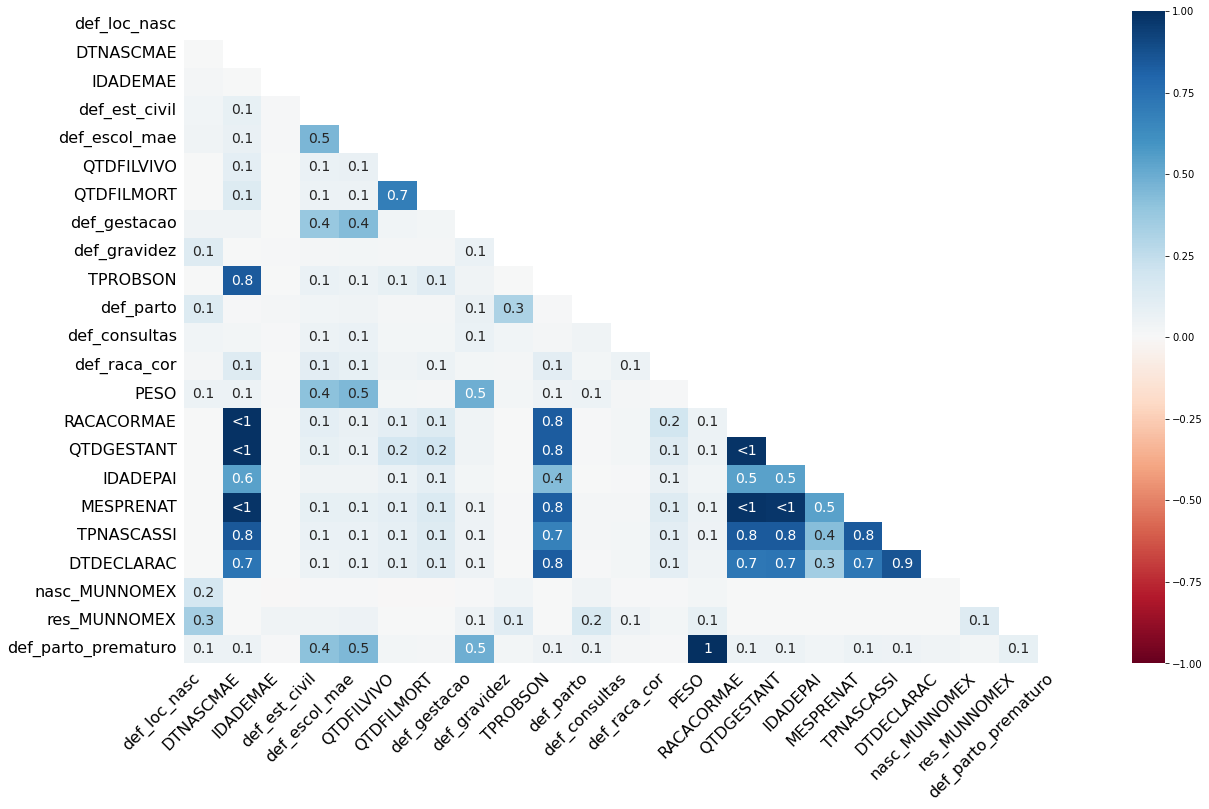

In [ ]:
msno.heatmap(df)

<AxesSubplot:>

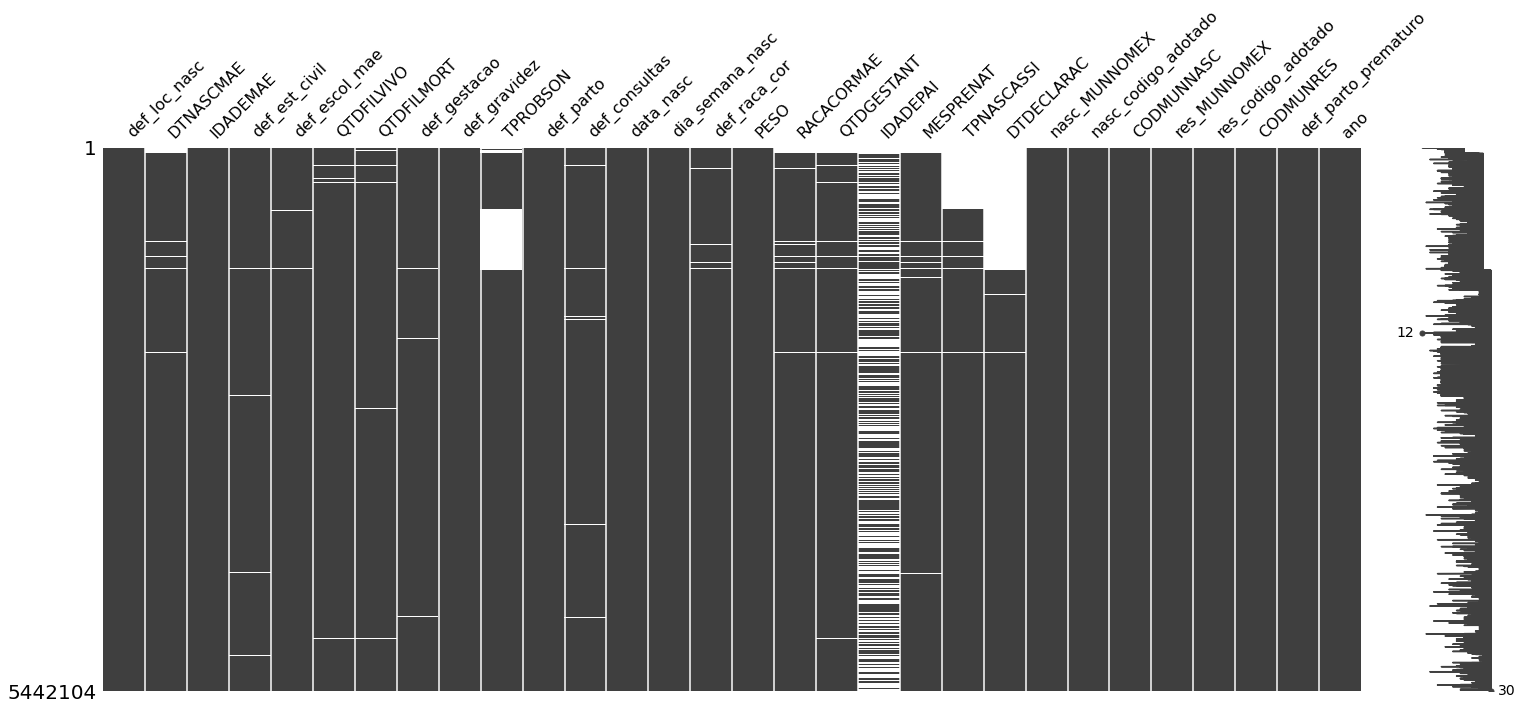

In [81]:
msno.matrix(df[(df['ano']>2011)])

### Select 2012-2022

In [220]:
df = df[(df['ano'].isin([i for i in range(2012, 2021)]))].copy()

In [221]:
df['ano'].unique()

array([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [85]:
dfa = pd.DataFrame()
for i in [str(i) for i in range(2012, 2021)]:
    dfa1 = pd.read_excel('C:/Users/joaom/Downloads/Historico-AB-MUNICIPIOS-2007-202012.xlsx',
                        sheet_name=i)
    dfa1['ano'] = i
    
    dfa = pd.concat([dfa, dfa1], axis=0, sort=False)

In [86]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601452 entries, 0 to 66839
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   NU_COMPETENCIA                601452 non-null  int64  
 1   CO_REGIAO                     601452 non-null  int64  
 2   SG_REGIAO                     601452 non-null  object 
 3   NO_REGIAO                     601452 non-null  object 
 4   CO_UF_IBGE                    601452 non-null  int64  
 5   NO_UF_ACENTUADO               601452 non-null  object 
 6   SG_UF                         601452 non-null  object 
 7   CO_MUNICIPIO_IBGE             601452 non-null  int64  
 8   NO_MUNICIPIO_ACENTUADO        601452 non-null  object 
 9   QT_EQUIPE_SF                  601452 non-null  float64
 10  QT_EQUIPE_AB_PARAMETRIZADA    601452 non-null  int64  
 11  QT_CH_MEDICO                  601452 non-null  object 
 12  QT_CH_ENFERMEIRO              601452 non-null

In [87]:
dfa = dfa[(dfa['SG_UF'] == 'SP')].copy()

In [88]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69660 entries, 57372 to 65171
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   NU_COMPETENCIA                69660 non-null  int64  
 1   CO_REGIAO                     69660 non-null  int64  
 2   SG_REGIAO                     69660 non-null  object 
 3   NO_REGIAO                     69660 non-null  object 
 4   CO_UF_IBGE                    69660 non-null  int64  
 5   NO_UF_ACENTUADO               69660 non-null  object 
 6   SG_UF                         69660 non-null  object 
 7   CO_MUNICIPIO_IBGE             69660 non-null  int64  
 8   NO_MUNICIPIO_ACENTUADO        69660 non-null  object 
 9   QT_EQUIPE_SF                  69660 non-null  float64
 10  QT_EQUIPE_AB_PARAMETRIZADA    69660 non-null  int64  
 11  QT_CH_MEDICO                  69660 non-null  object 
 12  QT_CH_ENFERMEIRO              69660 non-null  object 
 1

In [89]:
dfa['ano'].unique()

array(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020'], dtype=object)

In [90]:
dfa['QT_POPULACAO'].head(2)

57372    33.820
57373    33.820
Name: QT_POPULACAO, dtype: object

In [93]:
dfa['QT_POPULACAO'] = dfa['QT_POPULACAO'].str.replace('.', '').astype('int64')


C:\Users\joaom\AppData\Local\Temp/ipykernel_13028/1991275915.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dfa['QT_POPULACAO'] = dfa['QT_POPULACAO'].str.replace('.', '').astype('int64')


In [95]:
dfa['QT_POPULACAO'].isnull().mean()

0.0

In [94]:
dfa['QT_POPULACAO'].describe()

count    6.966000e+04
mean     6.836970e+04
std      4.800294e+05
min      8.060000e+02
25%      5.502000e+03
50%      1.342000e+04
75%      4.064000e+04
max      1.225202e+07
Name: QT_POPULACAO, dtype: float64

In [99]:
dfa['PC_COBERTURA_AB'] = dfa['PC_COBERTURA_AB'].str.replace(',', '.').astype(float)

In [100]:
dfa['PC_COBERTURA_AB'].isnull().mean()

0.0

In [101]:
dfa['PC_COBERTURA_AB'].describe()

count    69660.000000
mean        77.355783
std         27.238084
min          0.000000
25%         57.950000
50%         89.670000
75%        100.000000
max        100.000000
Name: PC_COBERTURA_AB, dtype: float64

In [96]:
dfa['PC_COBERTURA_SF'] = dfa['PC_COBERTURA_SF'].str.replace(',', '.').astype(float)

In [97]:
dfa['PC_COBERTURA_SF'].isnull().mean()

0.0

In [98]:
dfa['PC_COBERTURA_SF'].describe()

count    69660.000000
mean        62.381470
std         36.142563
min          0.000000
25%         30.947500
50%         70.700000
75%        100.000000
max        100.000000
Name: PC_COBERTURA_SF, dtype: float64

In [102]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69660 entries, 57372 to 65171
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   NU_COMPETENCIA                69660 non-null  int64  
 1   CO_REGIAO                     69660 non-null  int64  
 2   SG_REGIAO                     69660 non-null  object 
 3   NO_REGIAO                     69660 non-null  object 
 4   CO_UF_IBGE                    69660 non-null  int64  
 5   NO_UF_ACENTUADO               69660 non-null  object 
 6   SG_UF                         69660 non-null  object 
 7   CO_MUNICIPIO_IBGE             69660 non-null  int64  
 8   NO_MUNICIPIO_ACENTUADO        69660 non-null  object 
 9   QT_EQUIPE_SF                  69660 non-null  float64
 10  QT_EQUIPE_AB_PARAMETRIZADA    69660 non-null  int64  
 11  QT_CH_MEDICO                  69660 non-null  object 
 12  QT_CH_ENFERMEIRO              69660 non-null  object 
 1

In [105]:
dfp = dfa[['CO_MUNICIPIO_IBGE', 'QT_POPULACAO']].drop_duplicates('CO_MUNICIPIO_IBGE')

In [111]:
dfp['QT_POPULACAO'].describe().apply(lambda x: format(x, 'f'))

count         645.000000
mean        64475.801550
std        456984.220996
min           806.000000
25%          5182.000000
50%         12782.000000
75%         38193.000000
max      11316149.000000
Name: QT_POPULACAO, dtype: object

In [114]:
dfp.loc[(dfp['QT_POPULACAO'] > 5000), 'QT_POPULACAO'].describe().apply(lambda x: format(x, 'f'))

count         487.000000
mean        84329.211499
std        524513.674667
min          5070.000000
25%         10140.500000
50%         20372.000000
75%         51336.000000
max      11316149.000000
Name: QT_POPULACAO, dtype: object

### Get pop size for each municipality
For primary healthcare coverage they used the pop of 2006 for every year

In [222]:
df = pd.merge(df, dfp, left_on='res_codigo_adotado', right_on='CO_MUNICIPIO_IBGE', how='left')

In [223]:
df['QT_POPULACAO'].notnull().mean()

0.9999840135359412

In [224]:
df['res_codigo_adotado'].nunique()

646

### Select municipalities population >5000

In [225]:
df = df[(df['QT_POPULACAO'] > 5000)].copy()

<AxesSubplot:>

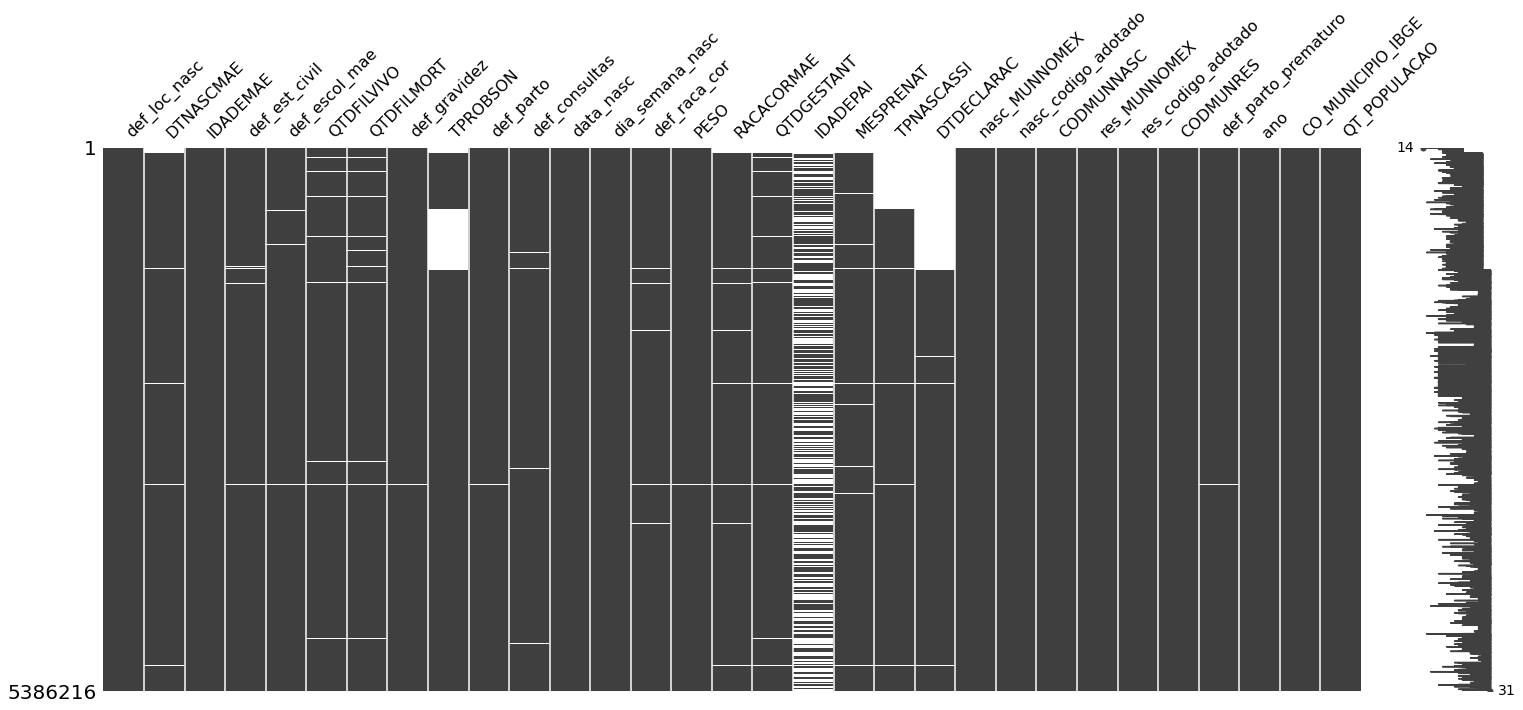

In [175]:
msno.matrix(df)

### Create aggregated features by municipality

Features
* 'def_loc_nasc': % hospital births
* 'IDADEMAE'
    * % pregnacies <=19 years of age
    * mean age of pregnancies
* 'def_est_civil': % married
* 'def_escol_mae': % 'Nenhuma' or 'de 1 a 3 anos'
* 'def_gravidez': % single pregnancy
* 'TPROBSON':
    * % 1-2
    * % 3-4
    * % 5
    * % 6-10
* 'def_parto':
    * % cesárea grupo 5 robson
    * % cesárea grupos 1-4
* 'def_consultas': % '7 ou mais'
* data_nasc: find year of birth
* 'dia_semana_nasc': % births on sat or sund
I think this one if an old format asking race of the newborn
* 'def_raca_cor': % not white
* 'PESO': % peso ao nascer <2500g
* 'RACACORMAE': % not withe
* 'QTDGESTANT': % >2 pregnancies
* 'MESPRENAT': % <=3 months
* 'TPNASCASSI': % birth conducted by MD


In [117]:
df['def_loc_nasc'].unique()

array(['Hospital', 'Domicílio', 'Outro Estab. Saúde', nan, 'Outros'],
      dtype=object)

In [128]:
df['def_est_civil'].unique()

array(['Solteiro', nan, 'Casado', 'Separado Judic./Divorciado', 'Viúvo',
       'União consensual'], dtype=object)

In [129]:
df['def_escol_mae'].unique()

array(['8 a 11 anos', '4 a 7 anos', '12 e mais', nan, 'Nenhuma',
       '1 a 3 anos'], dtype=object)

In [132]:
df['def_gravidez'].unique()

array(['Única', 'Dupla', 'Tripla ou mais', nan], dtype=object)

In [134]:
df['def_consultas'].unique()

array(['7 e mais', 'Nenhuma', 'de 4 a 6', 'de 1 a 3', nan], dtype=object)

In [135]:
df['dia_semana_nasc'].unique()

array(['sex', 'sab', 'ter', 'qui', 'seg', 'qua', 'dom'], dtype=object)

In [138]:
df['RACACORMAE'].unique()

array([nan, 'Branca', 'Parda', 'Preta', 'Indígena', 'Amarela', 9.0],
      dtype=object)

In [139]:
df['QTDGESTANT'].describe()

count    5.369585e+06
mean     1.126329e+00
std      1.389403e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.900000e+01
Name: QTDGESTANT, dtype: float64

In [141]:
df['TPNASCASSI'].unique()

array([nan, 'Médico', 'Enfermeira/obstetriz', 'Parteira', 'Outros'],
      dtype=object)

In [181]:
dic_var = {'def_loc_nasc':[['Hospital'], 'birth_hosp', 'birth_hosp_perc'],
'def_est_civil':[['Casado'], 'married', 'married_perc'],
'def_escol_mae':[['Nenhuma', '1 a 3 anos'], 'low_education', 'low_education_perc'],
'def_gravidez':[['Única'], 'single_preg', 'single_preg_perc'],
'TPROBSON':[[1, 2], 'rob12', 'rob12_perc'],
'TPROBSON':[[3, 4], 'rob34', 'rob34_perc'],
'TPROBSON':[[5], 'rob5', 'rob5_perc'],
'TPROBSON':[[6, 7, 8, 9, 10], 'rob610', 'rob610_perc'],
'def_consultas':[['7 e mais'], '7visits', '7visits_perc'],
'dia_semana_nasc':[['sab', 'dom'], 'weekend', 'weekend_perc'],
'RACACORMAE':[['Parda', 'Preta', 'Indígena', 'Amarela'], 'not_white', 'not_white_perc'],
'TPNASCASSI':[['Médico'], 'delivery_md', 'delivery_md_perc']}


In [278]:
df2 = df[['res_codigo_adotado', 'ano']].drop_duplicates(['res_codigo_adotado', 'ano'])
for key, value in dic_var.items():
    df[value[1]] = np.nan
    df.loc[(df[key].notnull()), value[1]] = 0
    df.loc[(df[key].isin(value[0])), value[1]] = 1
    
    dfc = df.groupby(['res_codigo_adotado', 'ano'])[[value[1]]].mean().reset_index().rename(columns={value[1]:value[2]})
    
    df2 = pd.merge(df2, dfc, on=['res_codigo_adotado', 'ano'], how='left')
    

In [279]:
df2.head()

res_codigo_adotado   ano  birth_hosp_perc  married_perc  \
0              350750  2012         0.997041      0.469194   
1              351030  2012         0.976834      0.437984   
2              355620  2012         0.996257      0.542922   
3              355030  2012         0.993201      0.369033   
4              353080  2012         1.000000      0.503051   

   low_education_perc  single_preg_perc  rob610_perc  7visits_perc  \
0            0.016607          0.986982     0.204154      0.871734   
1            0.059055          0.980695     0.200935      0.803089   
2            0.012801          0.963241     0.304012      0.858108   
3            0.014549          0.973963     0.166748      0.747099   
4            0.035088          0.977450     0.215090      0.767279   

   weekend_perc  not_white_perc  delivery_md_perc  
0      0.194675        0.080760               NaN  
1      0.223938        0.198113               NaN  
2      0.198353        0.281614               NaN  
3      0.245600        0.473350               NaN  
4      0.224631        0.224374               NaN

In [185]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487 entries, 0 to 486
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   res_codigo_adotado  487 non-null    int64  
 1   birth_hosp_perc     487 non-null    float64
 2   married_perc        487 non-null    float64
 3   low_education_perc  487 non-null    float64
 4   single_preg_perc    487 non-null    float64
 5   rob610_perc         487 non-null    float64
 6   7visits_perc        487 non-null    float64
 7   weekend_perc        487 non-null    float64
 8   not_white_perc      487 non-null    float64
 9   delivery_md_perc    487 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 41.9 KB


In [133]:
df['def_parto'].unique()

array(['Cesáreo', 'Vaginal', nan], dtype=object)

In [229]:
df['rob5_ces'] = np.nan
df.loc[(df['TPROBSON'].notnull()) & (df['def_parto'].notnull()), 'rob5_ces'] = 0
df.loc[(df['TPROBSON'].isin([5])) & (df['def_parto'] == 'Cesáreo'), 'rob5_ces'] = 1

df['rob14_ces'] = np.nan
df.loc[(df['TPROBSON'].notnull()) & (df['def_parto'].notnull()), 'rob14_ces'] = 0
df.loc[(df['TPROBSON'].isin([1, 2, 3, 4])) & (df['def_parto'] == 'Cesáreo'), 'rob14_ces'] = 1

In [137]:
df['PESO'].describe().apply(lambda x: format(x, 'f'))

count    8346960.000000
mean        3149.671505
std          551.377520
min          100.000000
25%         2875.000000
50%         3185.000000
75%         3490.000000
max         9999.000000
Name: PESO, dtype: object

In [140]:
df['MESPRENAT'].describe()

count    5.363291e+06
mean     4.569100e+00
std      1.454452e+01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      9.900000e+01
Name: MESPRENAT, dtype: float64

In [277]:
df['low_weight'] = np.nan
df.loc[(df['PESO'].notnull()), 'low_weight'] = 0
df.loc[(df['PESO'] <2500), 'low_weight'] = 1

In [231]:
df['numb_gest2'] = np.nan
df.loc[(df['QTDGESTANT'].notnull()), 'numb_gest2'] = 0
df.loc[(df['QTDGESTANT'] >2), 'numb_gest2'] = 1

In [232]:
df['1st_visit_3m'] = np.nan
df.loc[(df['MESPRENAT'].notnull()), '1st_visit_3m'] = 0
df.loc[(df['MESPRENAT'] <=3), '1st_visit_3m'] = 1

In [233]:
df['age_19'] = np.nan
df.loc[(df['IDADEMAE'].notnull()), 'age_19'] = 0
df.loc[(df['IDADEMAE'] <=19), 'age_19'] = 1

In [280]:
for i in ['rob5_ces', 'rob14_ces', 'low_weight', 'numb_gest2', '1st_visit_3m', 'age_19']:
    dfc = df.groupby(['res_codigo_adotado', 'ano'])[[i]].mean().reset_index().rename(columns={i:i+'_perc'})
    df2 = pd.merge(df2, dfc, on=['res_codigo_adotado', 'ano'], how='left')

In [297]:
df['def_parto_prematuro'].unique()

array(['Termo', nan, 'Inconclusivo-IG', 'Prematuro', 'Inconclusivo-Peso'],
      dtype=object)

In [298]:
df['premat'] = np.nan
df.loc[(df['def_parto_prematuro'].notnull()), 'premat'] = 0
df.loc[(df['def_parto_prematuro'] == 'Prematuro'), 'premat'] = 1

In [301]:
dfp = df.groupby(['res_codigo_adotado', 'ano'])[['premat']].mean().reset_index().rename(columns={'premat':'premat_1k'})
dfp['premat_1k'] = dfp['premat_1k']*1000
df2 = pd.merge(df2, dfp, on=['res_codigo_adotado', 'ano'], how='left')

In [302]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4383 entries, 0 to 4382
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   res_codigo_adotado  4383 non-null   int64  
 1   ano                 4383 non-null   int64  
 2   birth_hosp_perc     4383 non-null   float64
 3   married_perc        4383 non-null   float64
 4   low_education_perc  4383 non-null   float64
 5   single_preg_perc    4383 non-null   float64
 6   rob610_perc         3896 non-null   float64
 7   7visits_perc        4383 non-null   float64
 8   weekend_perc        4383 non-null   float64
 9   not_white_perc      4379 non-null   float64
 10  delivery_md_perc    3896 non-null   float64
 11  rob5_ces_perc       3896 non-null   float64
 12  rob14_ces_perc      3896 non-null   float64
 13  low_weight_perc     4383 non-null   float64
 14  numb_gest2_perc     4379 non-null   float64
 15  1st_visit_3m_perc   4379 non-null   float64
 16  age_19

In [282]:
age_mean = df.groupby(['res_codigo_adotado', 'ano'])[['IDADEMAE']].mean().reset_index().rename(columns={'IDADEMAE':'age_mean'})

In [283]:
age_mean.describe()

res_codigo_adotado          ano     age_mean
count         4383.000000  4383.000000  4383.000000
mean        352878.661191  2016.000000    26.782424
std           1673.848482     2.582283     1.037997
min         350010.000000  2012.000000    22.622222
25%         351440.000000  2014.000000    26.061771
50%         352770.000000  2016.000000    26.781250
75%         354350.000000  2018.000000    27.491504
max         355730.000000  2020.000000    31.366033

In [284]:
df2 = pd.merge(df2, age_mean, on=['res_codigo_adotado', 'ano'], how='left')

In [285]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4383 entries, 0 to 4382
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   res_codigo_adotado  4383 non-null   int64  
 1   ano                 4383 non-null   int64  
 2   birth_hosp_perc     4383 non-null   float64
 3   married_perc        4383 non-null   float64
 4   low_education_perc  4383 non-null   float64
 5   single_preg_perc    4383 non-null   float64
 6   rob610_perc         3896 non-null   float64
 7   7visits_perc        4383 non-null   float64
 8   weekend_perc        4383 non-null   float64
 9   not_white_perc      4379 non-null   float64
 10  delivery_md_perc    3896 non-null   float64
 11  rob5_ces_perc       3896 non-null   float64
 12  rob14_ces_perc      3896 non-null   float64
 13  low_weight_perc     4383 non-null   float64
 14  numb_gest2_perc     4379 non-null   float64
 15  1st_visit_3m_perc   4379 non-null   float64
 16  age_19

In [239]:
df2.head()

res_codigo_adotado   ano  birth_hosp_perc  married_perc  \
0              350750  2012         0.997041      0.469194   
1              351030  2012         0.976834      0.437984   
2              355620  2012         0.996257      0.542922   
3              355030  2012         0.993201      0.369033   
4              353080  2012         1.000000      0.503051   

   low_education_perc  single_preg_perc  rob610_perc  7visits_perc  \
0            0.016607          0.986982     0.204154      0.871734   
1            0.059055          0.980695     0.200935      0.803089   
2            0.012801          0.963241     0.304012      0.858108   
3            0.014549          0.973963     0.166748      0.747099   
4            0.035088          0.977450     0.215090      0.767279   

   weekend_perc  not_white_perc  delivery_md_perc  rob5_ces_perc  \
0      0.194675        0.080760               NaN       0.143027   
1      0.223938        0.198113               NaN       0.205607   
2      0.198353        0.281614               NaN       0.223765   
3      0.245600        0.473350               NaN       0.157089   
4      0.224631        0.224374               NaN       0.184893   

   rob14_ces_perc  low_weight_perc  numb_gest2_perc  1st_visit_3m_perc  \
0        0.275371              0.0         0.156083           0.868152   
1        0.242991              0.0         0.155660           0.844340   
2        0.270833              0.0         0.083656           0.806836   
3        0.263831              0.0         0.123673           0.810009   
4        0.298760              0.0         0.128848           0.811034   

   age_19_perc   age_mean  
0     0.154438  26.709467  
1     0.200772  25.247104  
2     0.095808  28.422156  
3     0.134363  27.488215  
4     0.143105  26.960971

### Get primary healthcare coverage

In [244]:
df2['ano'].dtype

dtype('int64')

In [245]:
dfa['ano'] = dfa['ano'].astype('int64')

In [246]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69660 entries, 57372 to 65171
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   NU_COMPETENCIA                69660 non-null  int64  
 1   CO_REGIAO                     69660 non-null  int64  
 2   SG_REGIAO                     69660 non-null  object 
 3   NO_REGIAO                     69660 non-null  object 
 4   CO_UF_IBGE                    69660 non-null  int64  
 5   NO_UF_ACENTUADO               69660 non-null  object 
 6   SG_UF                         69660 non-null  object 
 7   CO_MUNICIPIO_IBGE             69660 non-null  int64  
 8   NO_MUNICIPIO_ACENTUADO        69660 non-null  object 
 9   QT_EQUIPE_SF                  69660 non-null  float64
 10  QT_EQUIPE_AB_PARAMETRIZADA    69660 non-null  int64  
 11  QT_CH_MEDICO                  69660 non-null  object 
 12  QT_CH_ENFERMEIRO              69660 non-null  object 
 1

In [286]:
phc = dfa.groupby(['CO_MUNICIPIO_IBGE', 'ano'])[['PC_COBERTURA_SF']].mean().reset_index()

In [287]:
df2 = pd.merge(df2, phc, left_on=['res_codigo_adotado', 'ano'], right_on=['CO_MUNICIPIO_IBGE', 'ano'], how='left')

In [288]:
ab = dfa.groupby(['CO_MUNICIPIO_IBGE', 'ano'])[['PC_COBERTURA_AB']].mean().reset_index()

In [289]:
df2 = pd.merge(df2, ab, left_on=['res_codigo_adotado', 'ano'], right_on=['CO_MUNICIPIO_IBGE', 'ano'], how='left')

In [290]:
df2.drop(columns=['CO_MUNICIPIO_IBGE_x', 'CO_MUNICIPIO_IBGE_y'], inplace=True)

In [291]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4383 entries, 0 to 4382
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   res_codigo_adotado  4383 non-null   int64  
 1   ano                 4383 non-null   int64  
 2   birth_hosp_perc     4383 non-null   float64
 3   married_perc        4383 non-null   float64
 4   low_education_perc  4383 non-null   float64
 5   single_preg_perc    4383 non-null   float64
 6   rob610_perc         3896 non-null   float64
 7   7visits_perc        4383 non-null   float64
 8   weekend_perc        4383 non-null   float64
 9   not_white_perc      4379 non-null   float64
 10  delivery_md_perc    3896 non-null   float64
 11  rob5_ces_perc       3896 non-null   float64
 12  rob14_ces_perc      3896 non-null   float64
 13  low_weight_perc     4383 non-null   float64
 14  numb_gest2_perc     4379 non-null   float64
 15  1st_visit_3m_perc   4379 non-null   float64
 16  age_19

<AxesSubplot:>

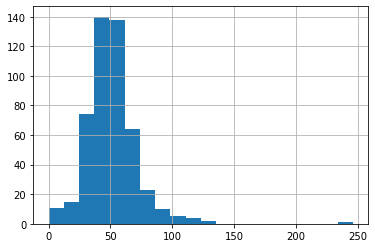

In [303]:
df2.loc[(df2['ano'] == 2012), 'premat_1k'].hist(bins=20)

<AxesSubplot:>

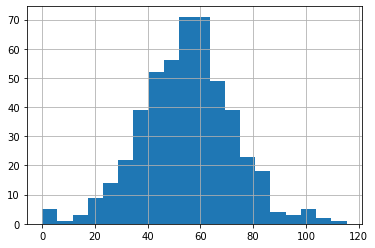

In [305]:
df2.loc[(df2['ano'] == 2020), 'premat_1k'].hist(bins=20)

In [121]:
variables2 = ['premat_1k', 'birth_hosp_perc', 'married_perc',
       'low_education_perc', 'single_preg_perc', 'rob610_perc', 'visits7_perc',
       'weekend_perc', 'not_white_perc', 'delivery_md_perc', 'rob5_ces_perc',
       'rob14_ces_perc', 'low_weight_perc', 'numb_gest2_perc',
       'first_visit_3m_perc', 'age_19_perc', 'age_mean', 'PC_COBERTURA_SF',
       'PC_COBERTURA_AB']

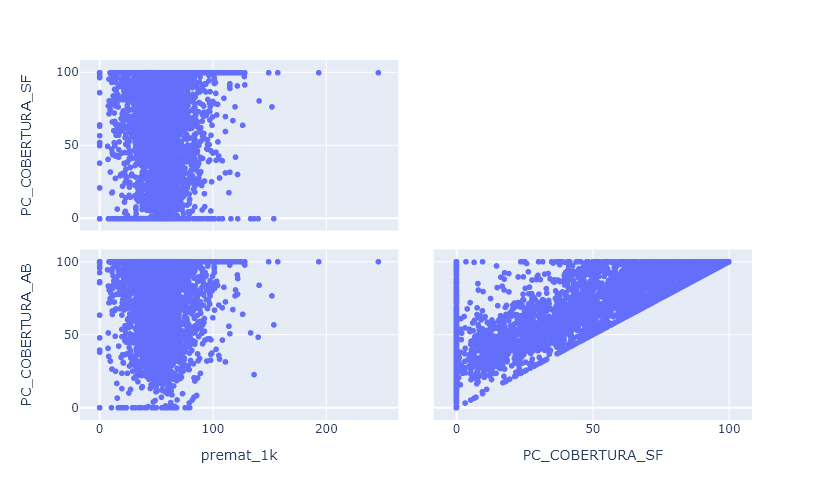

In [124]:
fig = px.scatter_matrix(df2, dimensions=['premat_1k', 'PC_COBERTURA_SF', 'PC_COBERTURA_AB'], color=None)

fig.update_layout(
        title=None,
        width=500,
        height=500,
    )

fig.update_traces(diagonal_visible=False, showupperhalf=False)

fig.show()

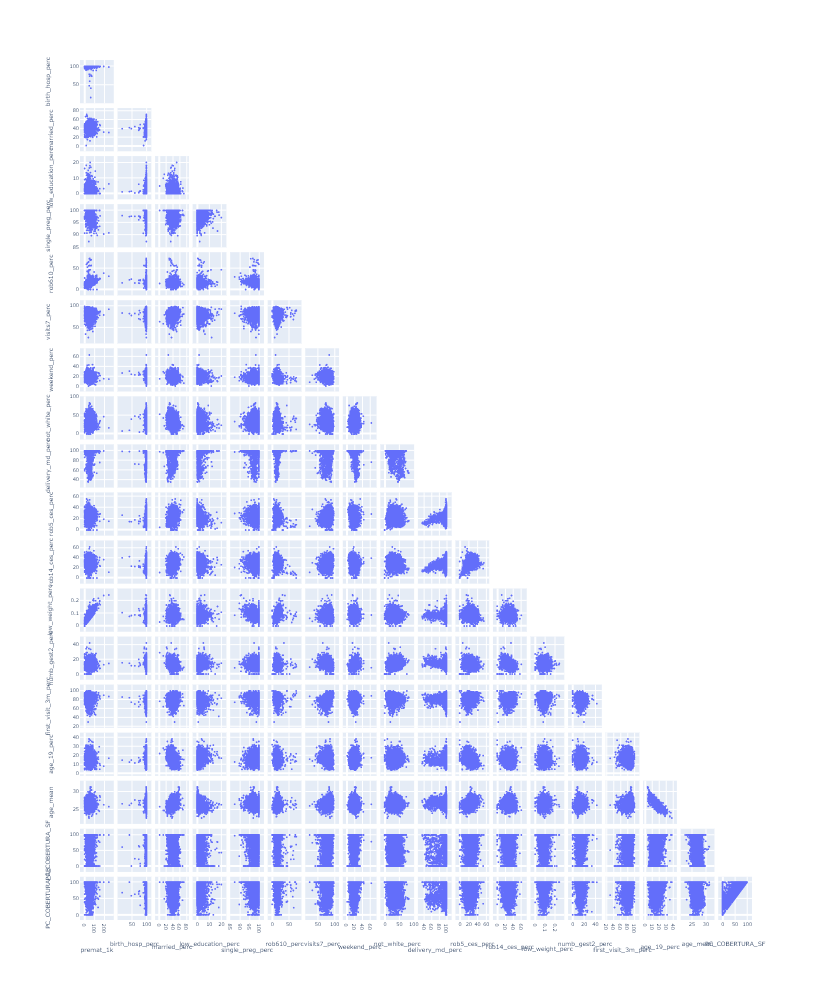

In [143]:
fig = px.scatter_matrix(df2, dimensions=variables2, color=None)

fig.update_layout(
        title=None,
        width=1000,
        height=1000,
    font=dict(
        family=None,
        size=5,
        color=None
    )
    )

fig.update_traces(
    marker=dict(size=2)
)

fig.update_traces(diagonal_visible=False, showupperhalf=False)

fig.show()

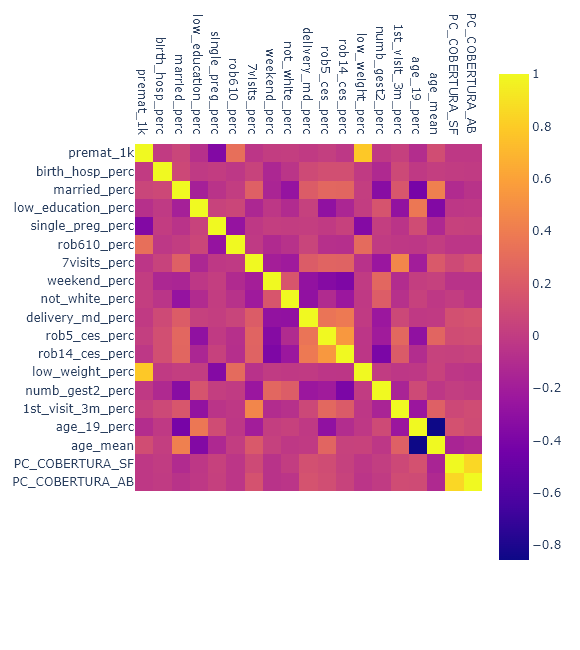

In [310]:
fig = px.imshow(df2[variables2].corr(method='pearson'))
fig.update_xaxes(side="top")
fig.update_layout(
        title=None,
        width=650,
        height=650,
    )
fig.show()

In [312]:
df2.to_excel('C:/Users/joaom/Downloads/prematurity_phc_coverage_features.xlsx', index=False)

In [50]:
df2 = pd.read_excel('C:/Users/crm107710/Downloads/prematurity_phc_coverage_features.xlsx')

In [51]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   res_codigo_adotado  4383 non-null   int64  
 1   ano                 4383 non-null   int64  
 2   birth_hosp_perc     4383 non-null   float64
 3   married_perc        4383 non-null   float64
 4   low_education_perc  4383 non-null   float64
 5   single_preg_perc    4383 non-null   float64
 6   rob610_perc         3896 non-null   float64
 7   7visits_perc        4383 non-null   float64
 8   weekend_perc        4383 non-null   float64
 9   not_white_perc      4379 non-null   float64
 10  delivery_md_perc    3896 non-null   float64
 11  rob5_ces_perc       3896 non-null   float64
 12  rob14_ces_perc      3896 non-null   float64
 13  low_weight_perc     4383 non-null   float64
 14  numb_gest2_perc     4379 non-null   float64
 15  1st_visit_3m_perc   4379 non-null   float64
 16  age_19

In [63]:
import statsmodels.formula.api as smf

In [64]:
model1 = smf.ols(formula='premat_1k ~ PC_COBERTURA_SF', data=df2).fit()

In [65]:
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              premat_1k   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.978
Date:                Sun, 16 Apr 2023   Prob (F-statistic):             0.0845
Time:                        08:41:03   Log-Likelihood:                -19134.
No. Observations:                4383   AIC:                         3.827e+04
Df Residuals:                    4381   BIC:                         3.828e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          54.0330      0.552     

In [66]:
model2 = smf.ols(formula='premat_1k ~ PC_COBERTURA_SF + PC_COBERTURA_AB', data=df2).fit()

In [67]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:              premat_1k   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.574
Date:                Sun, 16 Apr 2023   Prob (F-statistic):              0.207
Time:                        08:43:38   Log-Likelihood:                -19134.
No. Observations:                4383   AIC:                         3.827e+04
Df Residuals:                    4380   BIC:                         3.829e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          54.3642      0.975     

In [68]:
df2.columns

Index(['res_codigo_adotado', 'ano', 'birth_hosp_perc', 'married_perc',
       'low_education_perc', 'single_preg_perc', 'rob610_perc', '7visits_perc',
       'weekend_perc', 'not_white_perc', 'delivery_md_perc', 'rob5_ces_perc',
       'rob14_ces_perc', 'low_weight_perc', 'numb_gest2_perc',
       '1st_visit_3m_perc', 'age_19_perc', 'age_mean', 'PC_COBERTURA_SF',
       'PC_COBERTURA_AB', 'premat_1k'],
      dtype='object')

In [92]:
df2['res_codigo_adotado'].nunique()

487

In [107]:
df2.rename(columns={'7visits_perc':'visits7_perc', '1st_visit_3m_perc':'first_visit_3m_perc'}, inplace=True)

In [114]:
for i in ['birth_hosp_perc', 'married_perc', 'low_education_perc', 
'single_preg_perc', 'rob610_perc', 'visits7_perc', 'weekend_perc', 
'not_white_perc', 'delivery_md_perc', 'rob5_ces_perc', 'rob14_ces_perc',
'numb_gest2_perc', 'first_visit_3m_perc', 'age_19_perc']:
    df2[i] = df2[i]*100

In [115]:
formula3 = '''premat_1k ~ PC_COBERTURA_SF + PC_COBERTURA_AB +
birth_hosp_perc + married_perc + low_education_perc + 
single_preg_perc + rob610_perc + visits7_perc + weekend_perc + 
not_white_perc + delivery_md_perc + rob5_ces_perc + rob14_ces_perc
+ numb_gest2_perc + first_visit_3m_perc + 
age_19_perc + age_mean'''

In [116]:
model3 = smf.ols(formula=formula3, data=df2).fit()

In [117]:
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:              premat_1k   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     58.41
Date:                Sun, 16 Apr 2023   Prob (F-statistic):          1.38e-174
Time:                        11:30:20   Log-Likelihood:                -14393.
No. Observations:                3409   AIC:                         2.882e+04
Df Residuals:                    3391   BIC:                         2.893e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             337.7046    

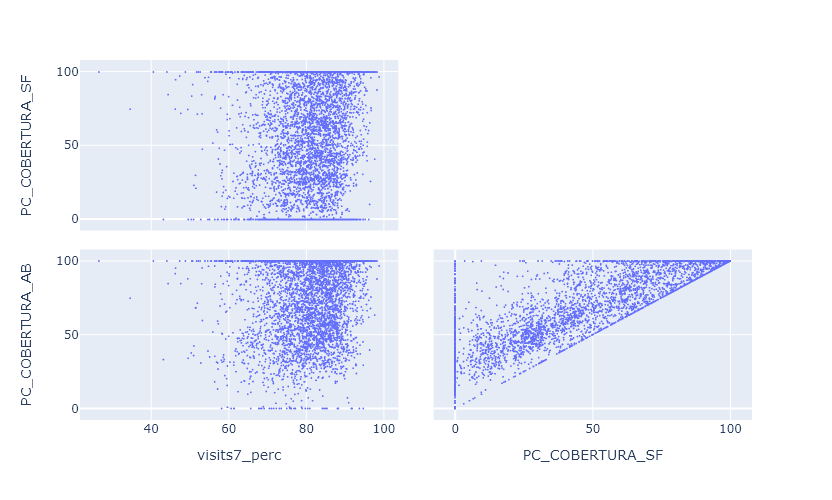

In [141]:
fig = px.scatter_matrix(df2, dimensions=['visits7_perc', 'PC_COBERTURA_SF', 'PC_COBERTURA_AB'], color=None,)

fig.update_layout(
        title=None,
        width=500,
        height=500,
    )

fig.update_traces(
    marker=dict(size=2)
)

fig.update_traces(diagonal_visible=False, showupperhalf=False)

fig.show()

In [127]:
model4 = smf.ols(formula='visits7_perc ~ PC_COBERTURA_SF', data=df2).fit()

In [128]:
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:           visits7_perc   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     37.75
Date:                Sun, 16 Apr 2023   Prob (F-statistic):           8.74e-10
Time:                        12:06:34   Log-Likelihood:                -15433.
No. Observations:                4383   AIC:                         3.087e+04
Df Residuals:                    4381   BIC:                         3.088e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          79.4842      0.237    3